**Временной лаг** - запаздывание
**Тренд** - долгосрочное изменение уровня ряда
**Сезонность** - циклические изменения уровня ряда с постоянным периодом
**Случайные** колебания - непрогнозируемые случайное изменение ряда

Одномерный временной ряд называется **стационарным**, если его вероятностные характеристики (параметры случайной величины) постоянны.
Временной ряд называется **нестационарным**, если хотя бы одна из вероятностных характеристик непостоянна.

Нулевая гипотеза предполагает, что процесс не стационарный
Альтернативная гипотеза говорит об обратном


## Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
psg = pd.read_csv('passengers.csv', index_col='Month', parse_dates=True)
psg.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [12]:
psg.resample(rule='YS').mean().head()

,#Passengers
Month,
1949-01-01,126.666667
1950-01-01,139.666667
1951-01-01,170.166667
1952-01-01,197.000000
1953-01-01,225.000000


In [15]:
psg.rolling(window=3).mean().head()

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,120.666667
1949-04-01,126.333333
1949-05-01,127.333333


[Text(0.5, 1.0, 'Перевозки пассажиров с 1949 по 1960 года'),
 Text(0.5, 0, 'Months'),
 Text(0, 0.5, 'N of passengers')]

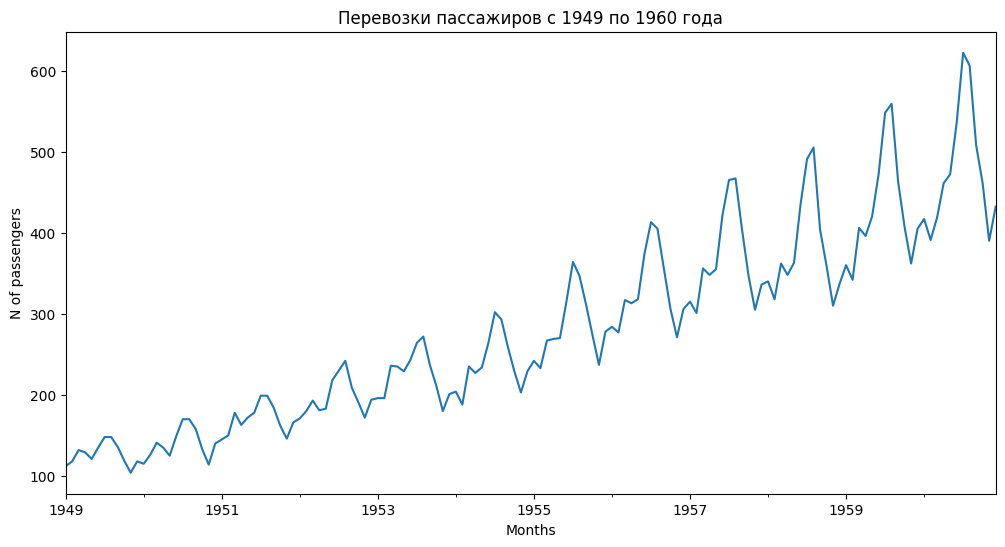

In [18]:
ax = psg.plot(figsize=(12, 6), legend=None)
ax.set(title='Перевозки пассажиров с 1949 по 1960 года', xlabel='Months', ylabel='N of passengers')

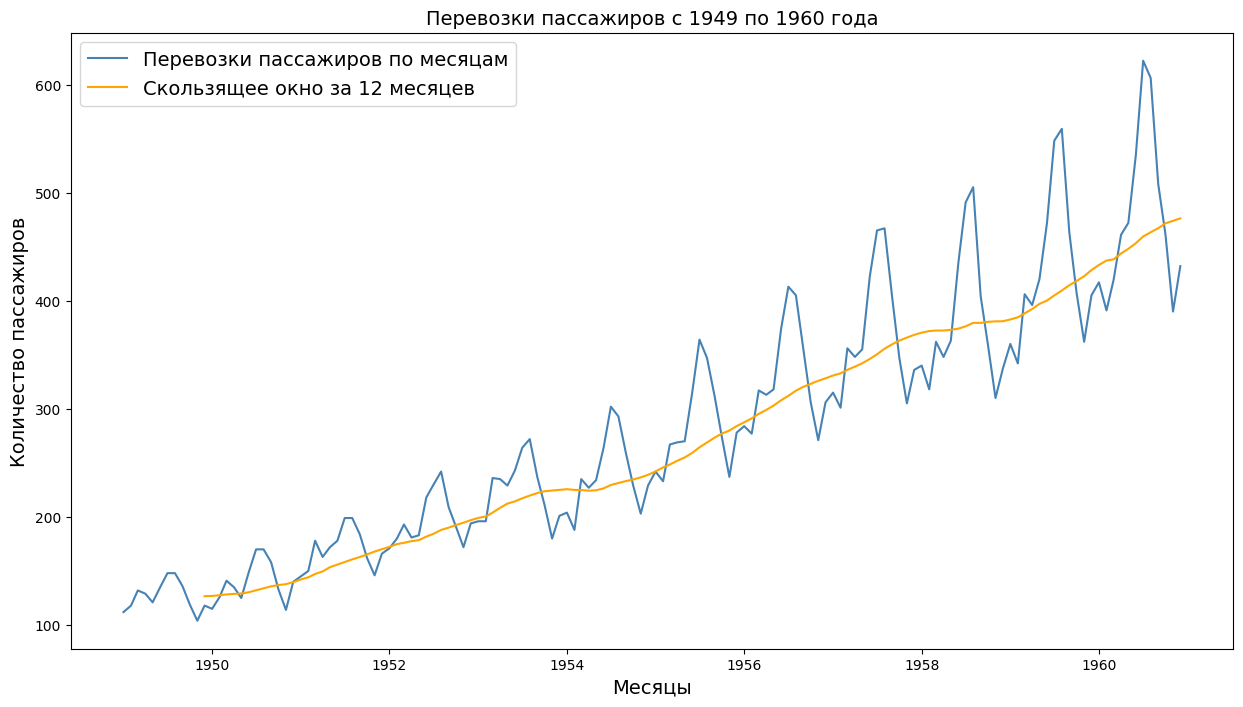

In [19]:
plt.figure(figsize=(15, 8))

plt.plot(psg, label='Перевозки пассажиров по месяцам', color='steelblue')
plt.plot(psg.rolling(window=12).mean(), label='Скользящее окно за 12 месяцев', color='orange')

plt.legend(loc='upper left', fontsize=14)

plt.ylabel('Количество пассажиров', fontsize=14)
plt.xlabel('Месяцы', fontsize=14)
plt.title('Перевозки пассажиров с 1949 по 1960 года', fontsize=14)

plt.show()

In [21]:
births = pd.read_csv('births.csv', index_col='Date', parse_dates=True)
births.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


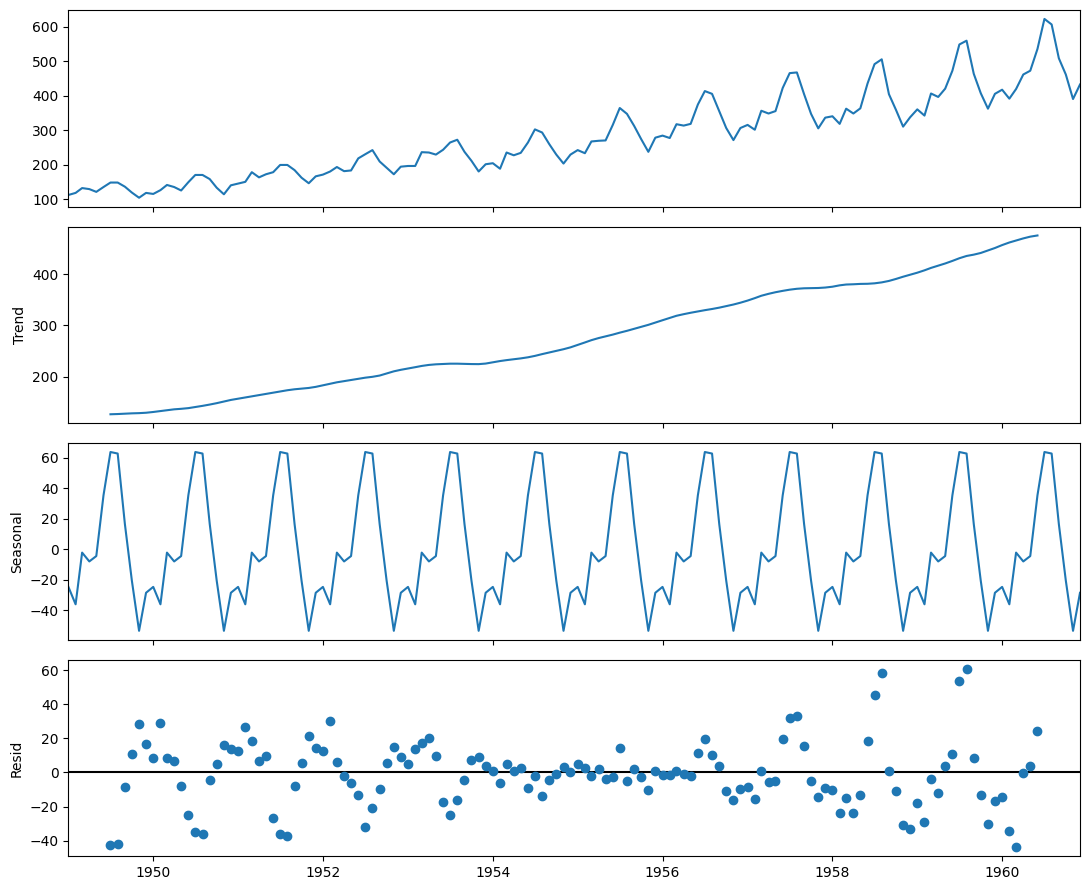

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose

from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

decompose = seasonal_decompose(psg)
decompose.plot()

plt.show()

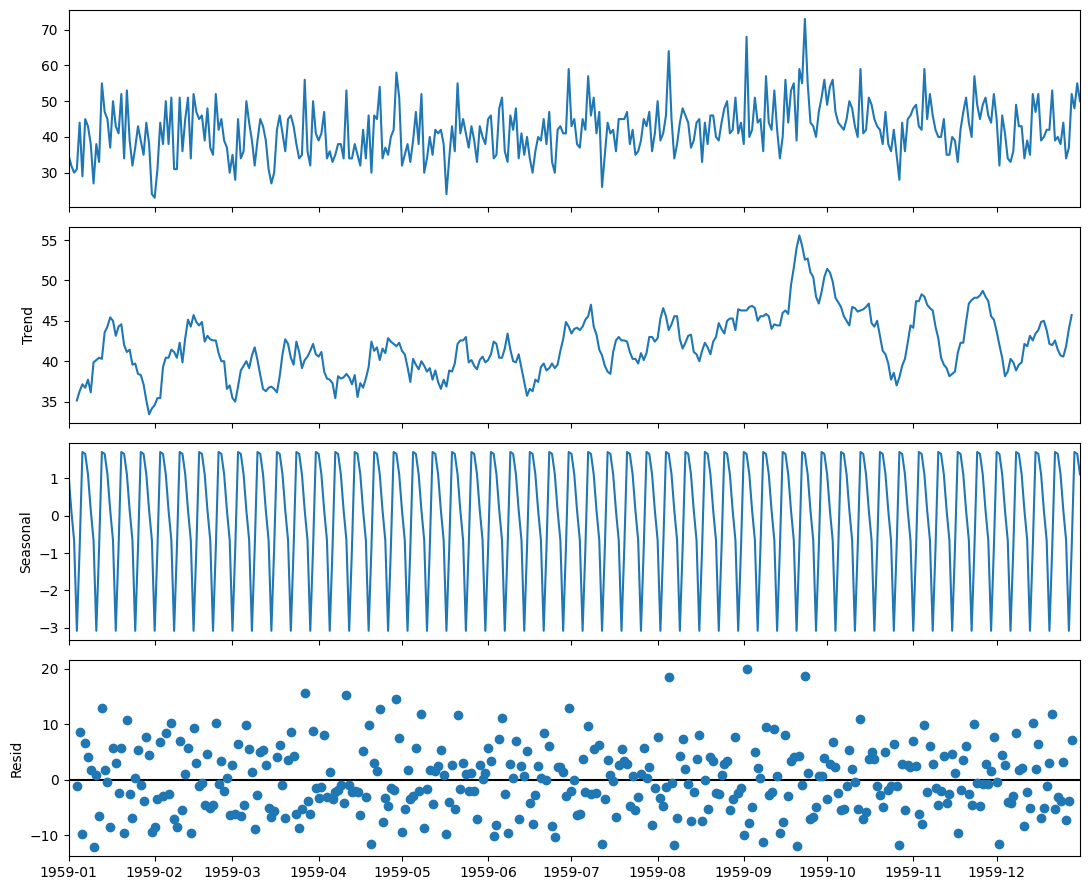

In [23]:
birth_decompose = seasonal_decompose(births)
birth_decompose.plot()
plt.show()

Проведем тест Дики-Фуллера

In [27]:
from statsmodels.tsa.stattools import adfuller

df_test = adfuller(psg['#Passengers'])

print('p-value = ' + str(df_test[1]))

p-value = 0.991880243437641


In [28]:
df_test = adfuller(births['Births'])

print('p-value = ' + str(df_test[1]))

p-value = 5.243412990149865e-05


### Автокорреляция

In [29]:
data = np.array([16, 21, 15, 24, 18, 17, 20])

lag_1 = data[1:]
np.round(np.corrcoef(data[:-1], lag_1)[0, 1], 2)

-0.71

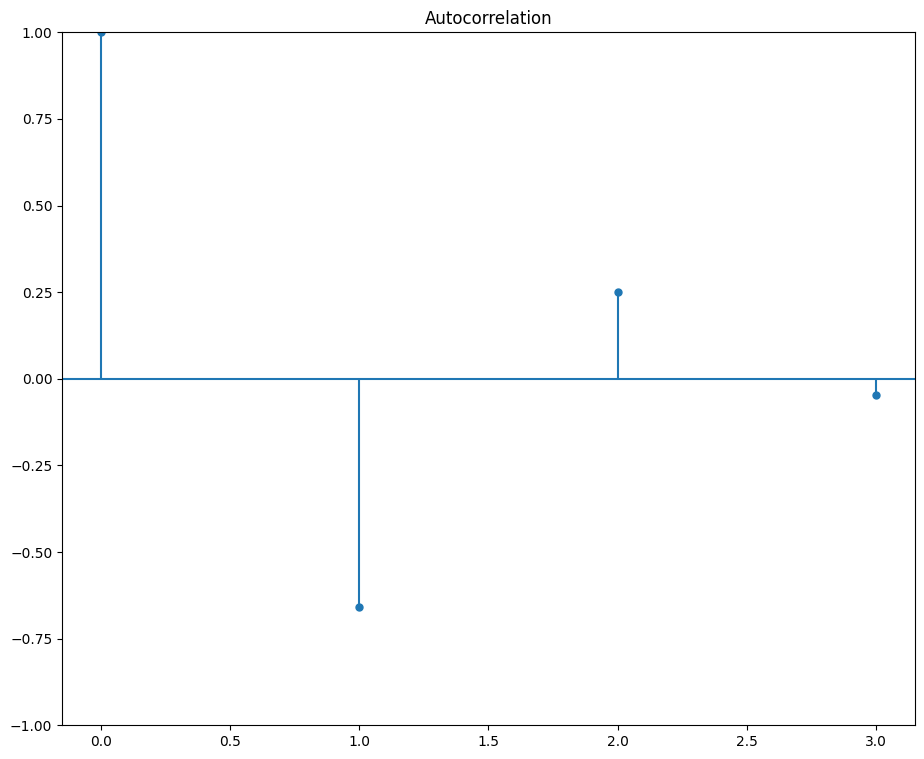

In [35]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(data, alpha=None)
plt.show()

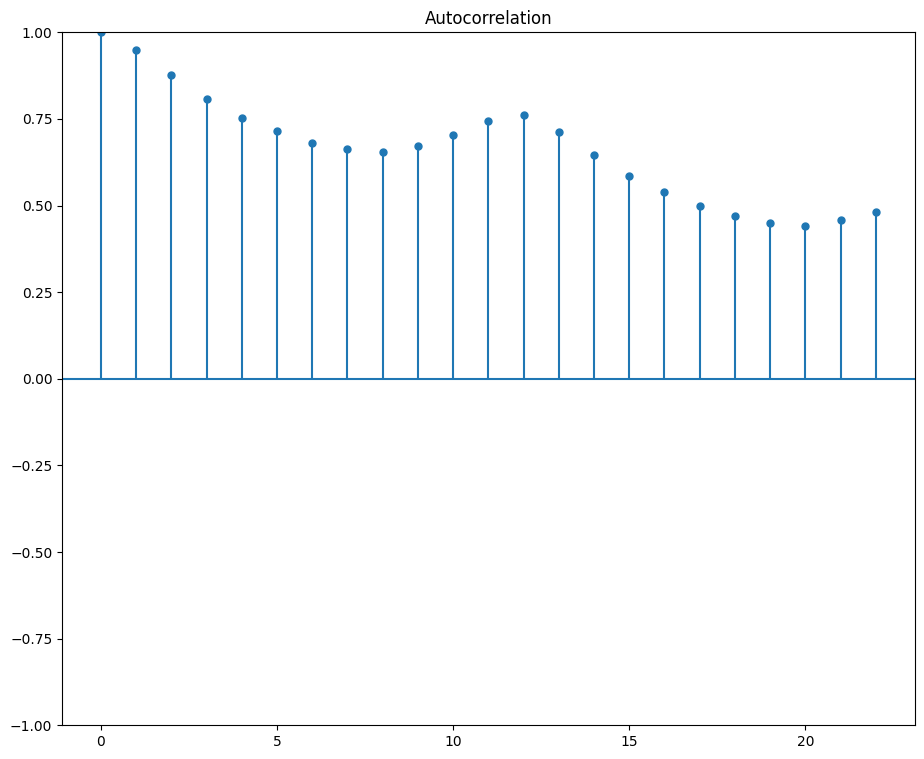

In [34]:
plot_acf(psg, alpha=None)
plt.show()

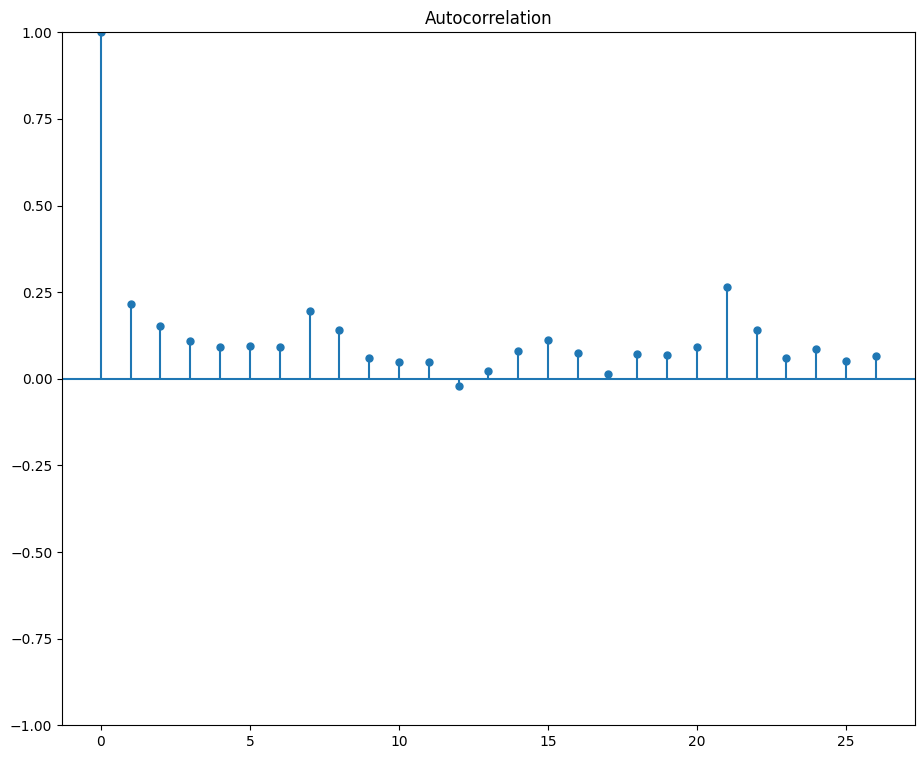

In [33]:
plot_acf(births, alpha=None)
plt.show()

## Моделирование и построение прогноза

Экспоненциальное сглаживание. В модели экспоненциального сглаживания (exponential smoothing) мы берем *все* предыдущие значения и задаем каждому из наблюдений определенный вес и экспоненциально уменьшаем этот вес по мере углубления в прошлое

$$
\widehat{y_{t}} = \alpha * y_{t} + (1 - \alpha) * \widehat{y}_{t - 1}
$$

где $\widehat{y}_{t}$ - это прогнозное значение, $y_{t}$- текущее истинное значение, $\widehat{y}_{t - 1}$ - предыдущее прогнозное значение

Важность значение определяется параметром $\alpha$

In [52]:
alpha = 0.2

# первое значение совпадает со значением временного ряда
exp_smoothing = [births['Births'][0]]

# в цикле for последовательно применяем формулу ко всем элементам ряда
for i in range(1, len(births['Births'])):
  exp_smoothing.append(alpha * births['Births'][i] + (1 - alpha) * exp_smoothing[i - 1])

# выведем прогнозное значение для 366-го дня (1 января 1960 года)
exp_smoothing[-1]

C:\Users\Stas\AppData\Local\Temp\ipykernel_7272\2723257258.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  exp_smoothing = [births['Births'][0]]
C:\Users\Stas\AppData\Local\Temp\ipykernel_7272\2723257258.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  exp_smoothing.append(alpha * births['Births'][i] + (1 - alpha) * exp_smoothing[i - 1])


46.6051933602952

In [53]:
births['Exp_smoothing'] = exp_smoothing
births.tail(3)

,Births,Exp_smoothing
Date,,
1959-12-29,48,43.445615
1959-12-30,55,45.756492
1959-12-31,50,46.605193


In [54]:
from datetime import timedelta

# возьмём последний индекс (31 декабря 1959 года)
last_date = births.iloc[[-1]].index

# # "прибавим" один день
last_date = last_date + timedelta(days = 1)

# добавим его в датафрейм
births = pd.concat([births, pd.DataFrame(index = last_date)])

# значения за этот день останутся пустыми
births.tail()

,Births,Exp_smoothing
Date,,
1959-12-28,52.0,42.307018
1959-12-29,48.0,43.445615
1959-12-30,55.0,45.756492
1959-12-31,50.0,46.605193
1960-01-01,NaN,NaN


In [55]:
births['Exp_smoothing'] = births['Exp_smoothing'].shift(1)

In [58]:
births.tail()

,Births,Exp_smoothing
Date,,
1959-12-28,52.0,39.883773
1959-12-29,48.0,42.307018
1959-12-30,55.0,43.445615
1959-12-31,50.0,45.756492
1960-01-01,NaN,46.605193


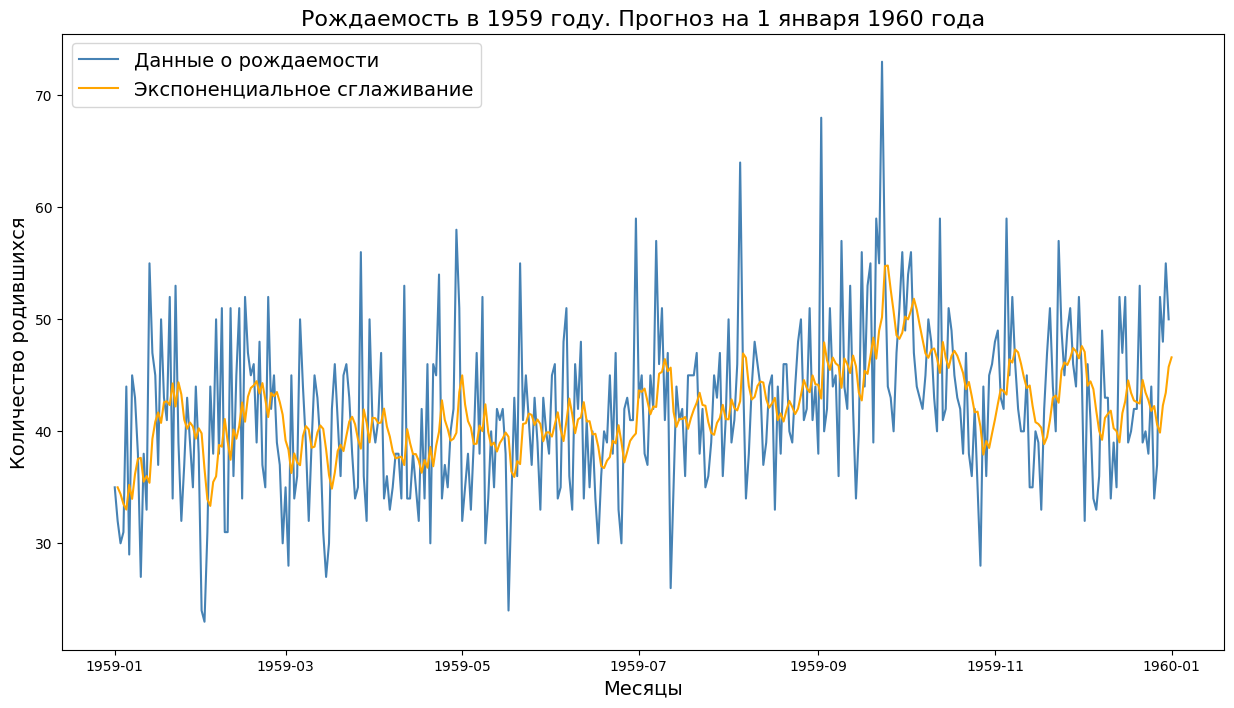

In [57]:
# посмотрим на результат на графике

# зададим размер
plt.figure(figsize = (15,8))

# выведем данные о рождаемости и кривую экспоненциального сглаживания
plt.plot(births['Births'], label = 'Данные о рождаемости', color = 'steelblue')
plt.plot(births['Exp_smoothing'], label = 'Экспоненциальное сглаживание', color = 'orange')

# добавим легенду, ее положение на графике и размер шрифта
plt.legend(title = '', loc = 'upper left', fontsize = 14)

# добавим подписи к осям и заголовки
plt.ylabel('Количество родившихся', fontsize = 14)
plt.xlabel('Месяцы', fontsize = 14)
plt.title('Рождаемость в 1959 году. Прогноз на 1 января 1960 года', fontsize = 16)

plt.show()

## ARMA

AutoRegression Moving Average

In [61]:
train = psg[:'1959-12']
test = psg['1960-01':]

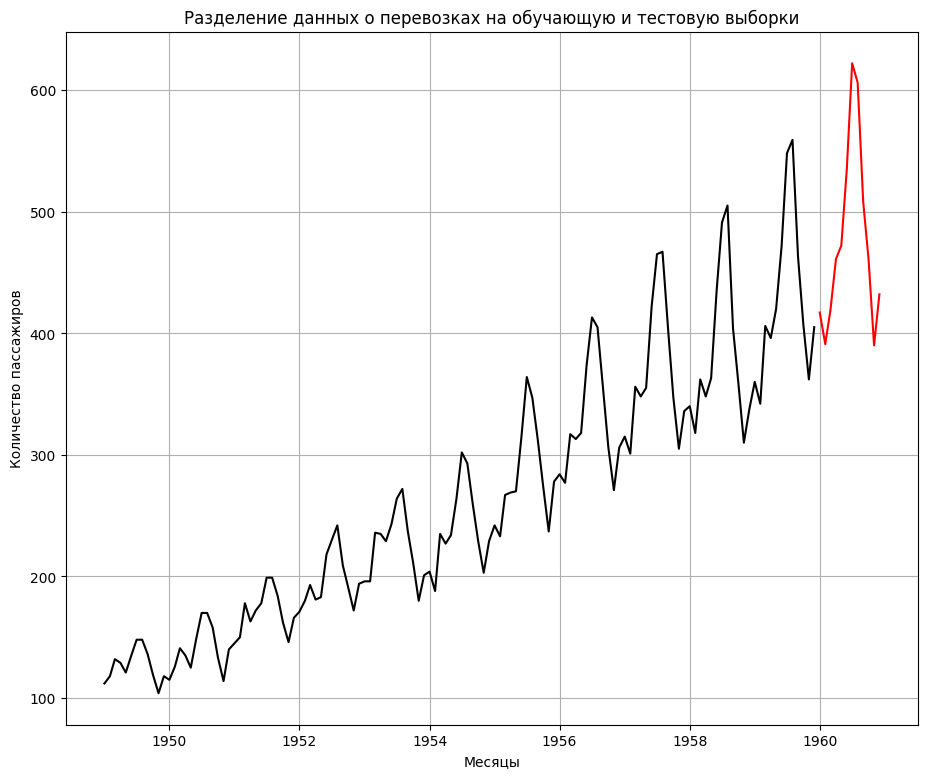

In [62]:
plt.plot(train, color = "black")
plt.plot(test, color = "red")

# заголовок и подписи к осям
plt.title('Разделение данных о перевозках на обучающую и тестовую выборки')
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')

# добавим сетку
plt.grid()

plt.show()

In [74]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
  train,
  order=(3, 0, 0),
  seasonal_order=(0, 1, 0, 12)
)

result = model.fit()

C:\Users\Stas\PycharmProjects\advanced-python\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Stas\PycharmProjects\advanced-python\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


In [71]:
print(result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        #Passengers   No. Observations:                  132
Model:             SARIMAX(3, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -451.953
Date:                            Wed, 12 Jun 2024   AIC                            911.907
Time:                                    17:27:00   BIC                            923.056
Sample:                                01-01-1949   HQIC                           916.435
                                     - 12-01-1959                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7603      0.088      8.672      0.000       0.588       0.932
ar.L2          0.2875      0.133   

In [72]:
start = len(train)
end = len(train) + len(test) - 1

prediction = result.predict(start, end)
prediction

1960-01-01    422.703386
1960-02-01    404.947179
1960-03-01    466.293259
1960-04-01    454.781298
1960-05-01    476.848630
1960-06-01    527.162828
1960-07-01    601.449812
1960-08-01    610.821694
1960-09-01    513.229990
1960-10-01    455.692622
1960-11-01    409.200050
1960-12-01    450.754164
Freq: MS, Name: predicted_mean, dtype: float64

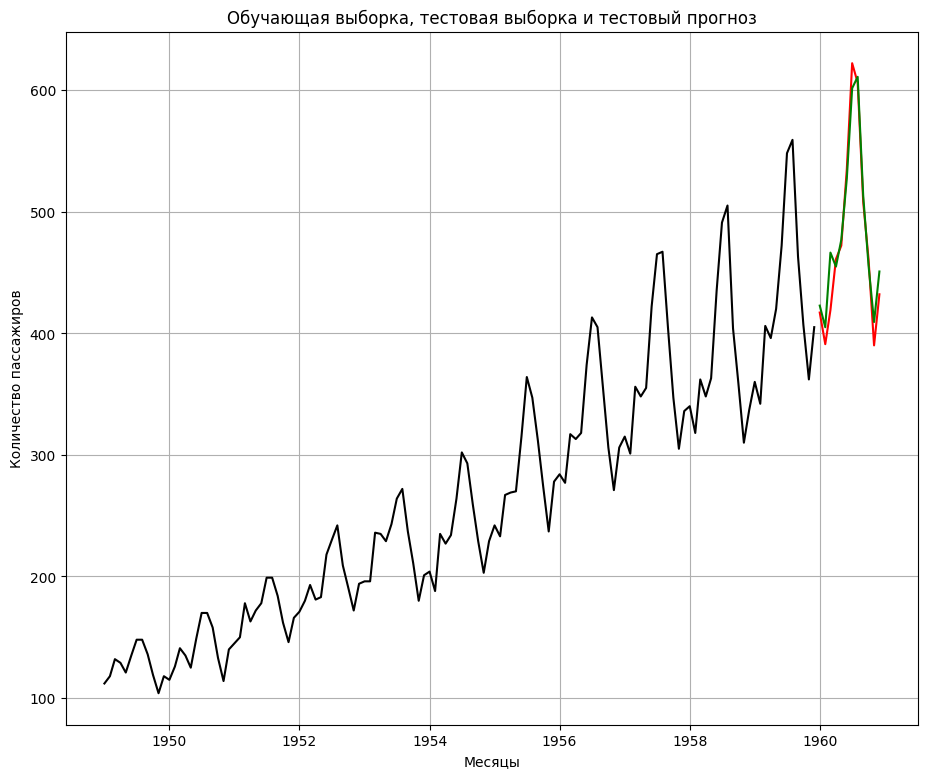

In [73]:
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(prediction, color = "green")

# заголовок и подписи к осям
plt.title("Обучающая выборка, тестовая выборка и тестовый прогноз")
plt.ylabel('Количество пассажиров')
plt.xlabel('Месяцы')

# добавим сетку
plt.grid()

plt.show()